In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from glob import glob
import os

import sys
sys.path.insert(0,r'/home/markus/repos/uni/16ma/bicycle/python')
from models.load_data_set import load_trajectories
from bicycle.plot_bicycle_trajectories import position, state
from bicycle import test_set, reward_functions
import evaluate

In [3]:
import holoviews as hv

hv.notebook_extension()
hv.ipython.display_hooks.ABBREVIATE_TRACEBACKS = False
%output holomap='auto' widgets='embed'
%output size=150 dpi=120 
%opts Points (s=20) Overlay
%opts Spread (alpha=0.4)
%opts Curve[show_title=True, title_format='{label}']
%opts Overlay[show_title=True show_grid=True title_format='{label}']
%opts Overlay.State[xaxis='bare', yaxis='bare']
%opts GridMatrix[padding=0.25 show_title=False xaxis=None yaxis=None normalize=False shared_xaxis=False shared_yaxis=False] {+framewise}
%opts Layout[show_title=True]
%opts NdOverlay[legend_cols=3 legend_position="bottom"] Points (color=Palette('Set1'))

In [4]:
from glob import glob
import os, re

def path_to_dump_name(path):
    path = os.path.basename(path)
    path = re.sub('\.[^.]+\.npy', '', path)
    return path

def nice_dump_name(dump_name):
    parsed = dict(map(lambda x: x.split('='), dump_name.split('__')))
    if "posterior" in parsed:
        return " ".join("{}={}".format(k, parsed[k]) for k in ["posterior", "N", "M"])
    else:
        return " ".join("{}={}".format(k, parsed[k]) for k in ["simulation"])
    
def maybe_int(x):
    try:
        return int(x)
    except ValueError:
        return x
    
def parse_path(path, items=["posterior", "N", "M"]):
    short = path_to_dump_name(path)
    parsed = dict(map(lambda x: x.split("="), short.split("__")))
    if "no_posterior" in parsed["name"]:
        parsed["posterior"] = parsed["posterior"] + "_no_truncation"
    if "posterior" in parsed:
        return tuple(map(lambda it: maybe_int(parsed[it]), items))
    else:
        return ("simulation", 0, 0)   

In [5]:
dump_globs = [
    '*'
]
ignore_globs = [
]
dump_path = r'/home/markus/repos/uni/16ma/bicycle/eval_trajectories/26/trajectories/'

trajectories = load_trajectories(dump_path, dump_globs, ignore_globs)

b':NdLayout   [Posterior]\n   :HoloMap   [M,N]\n      :NdOverlay   [Start State]\n         :Points   [x,y]'
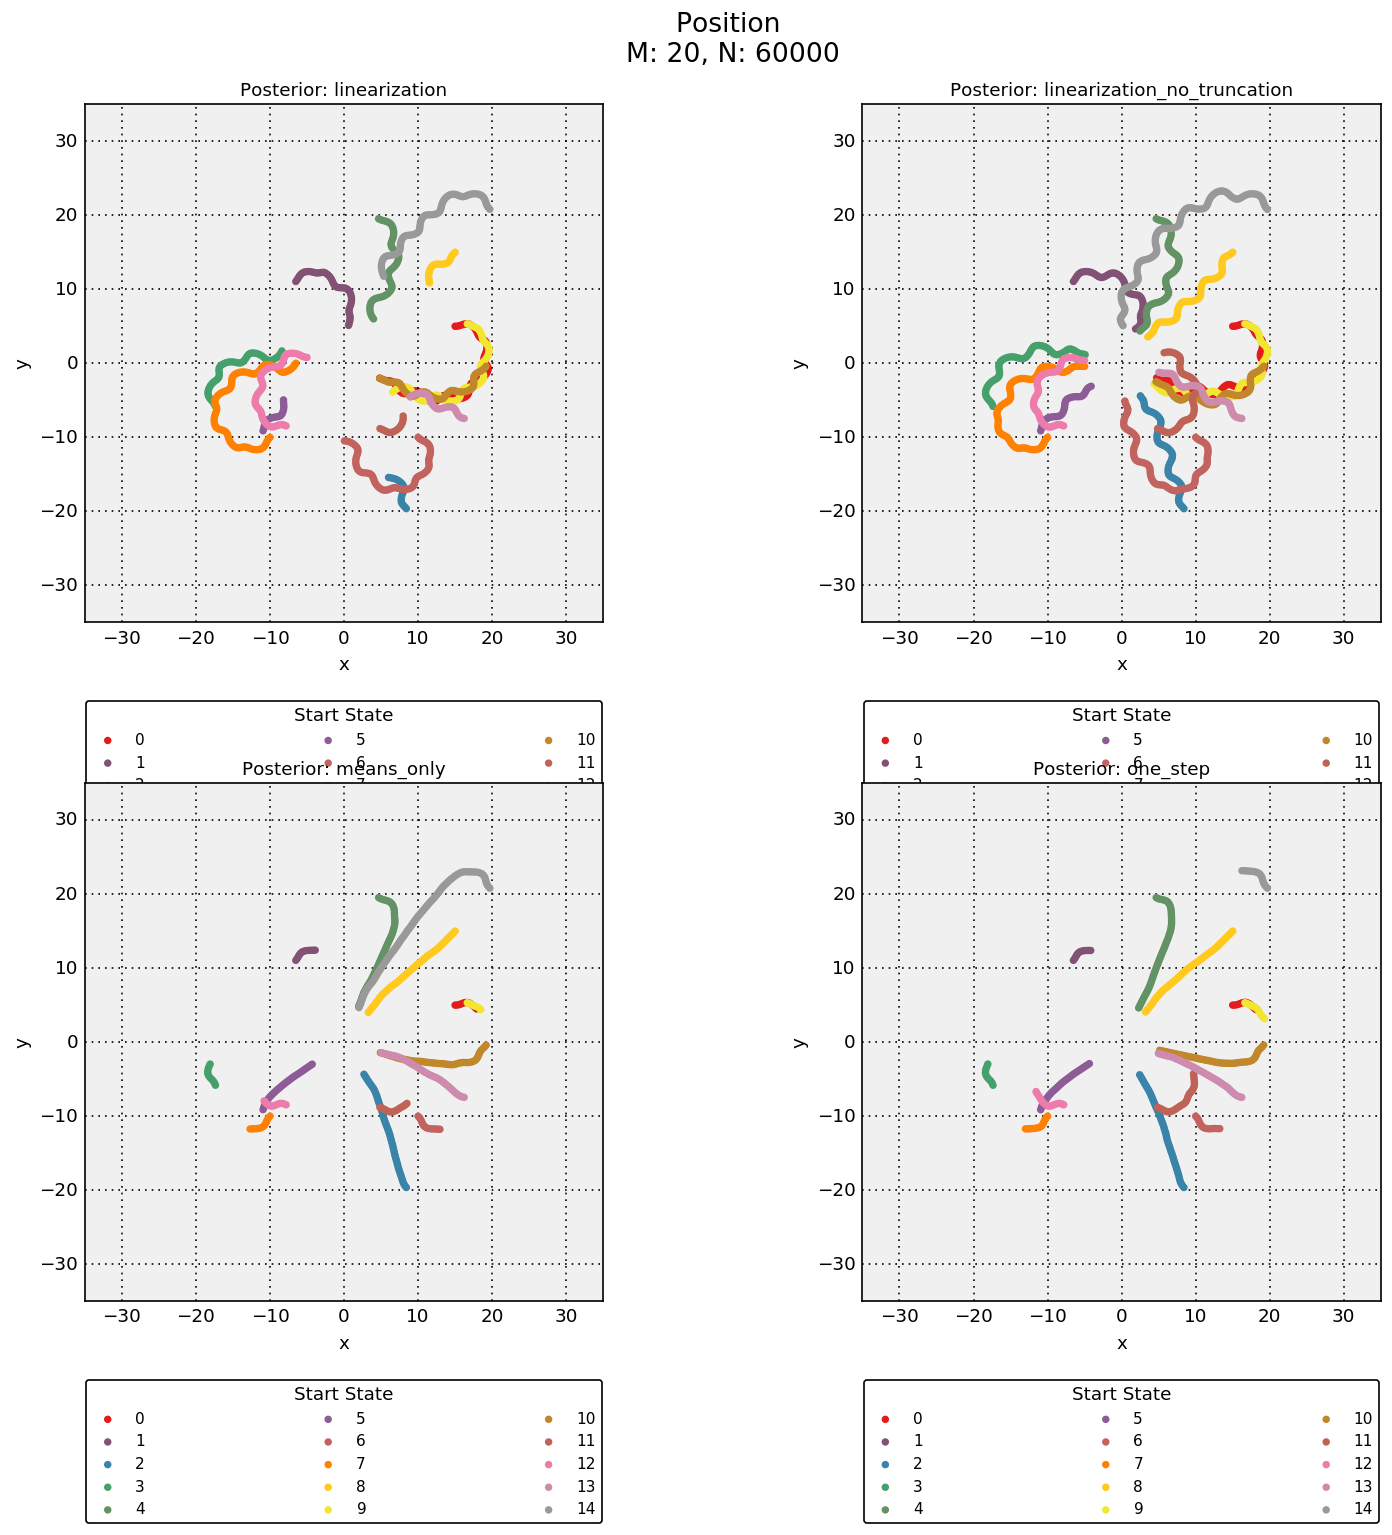
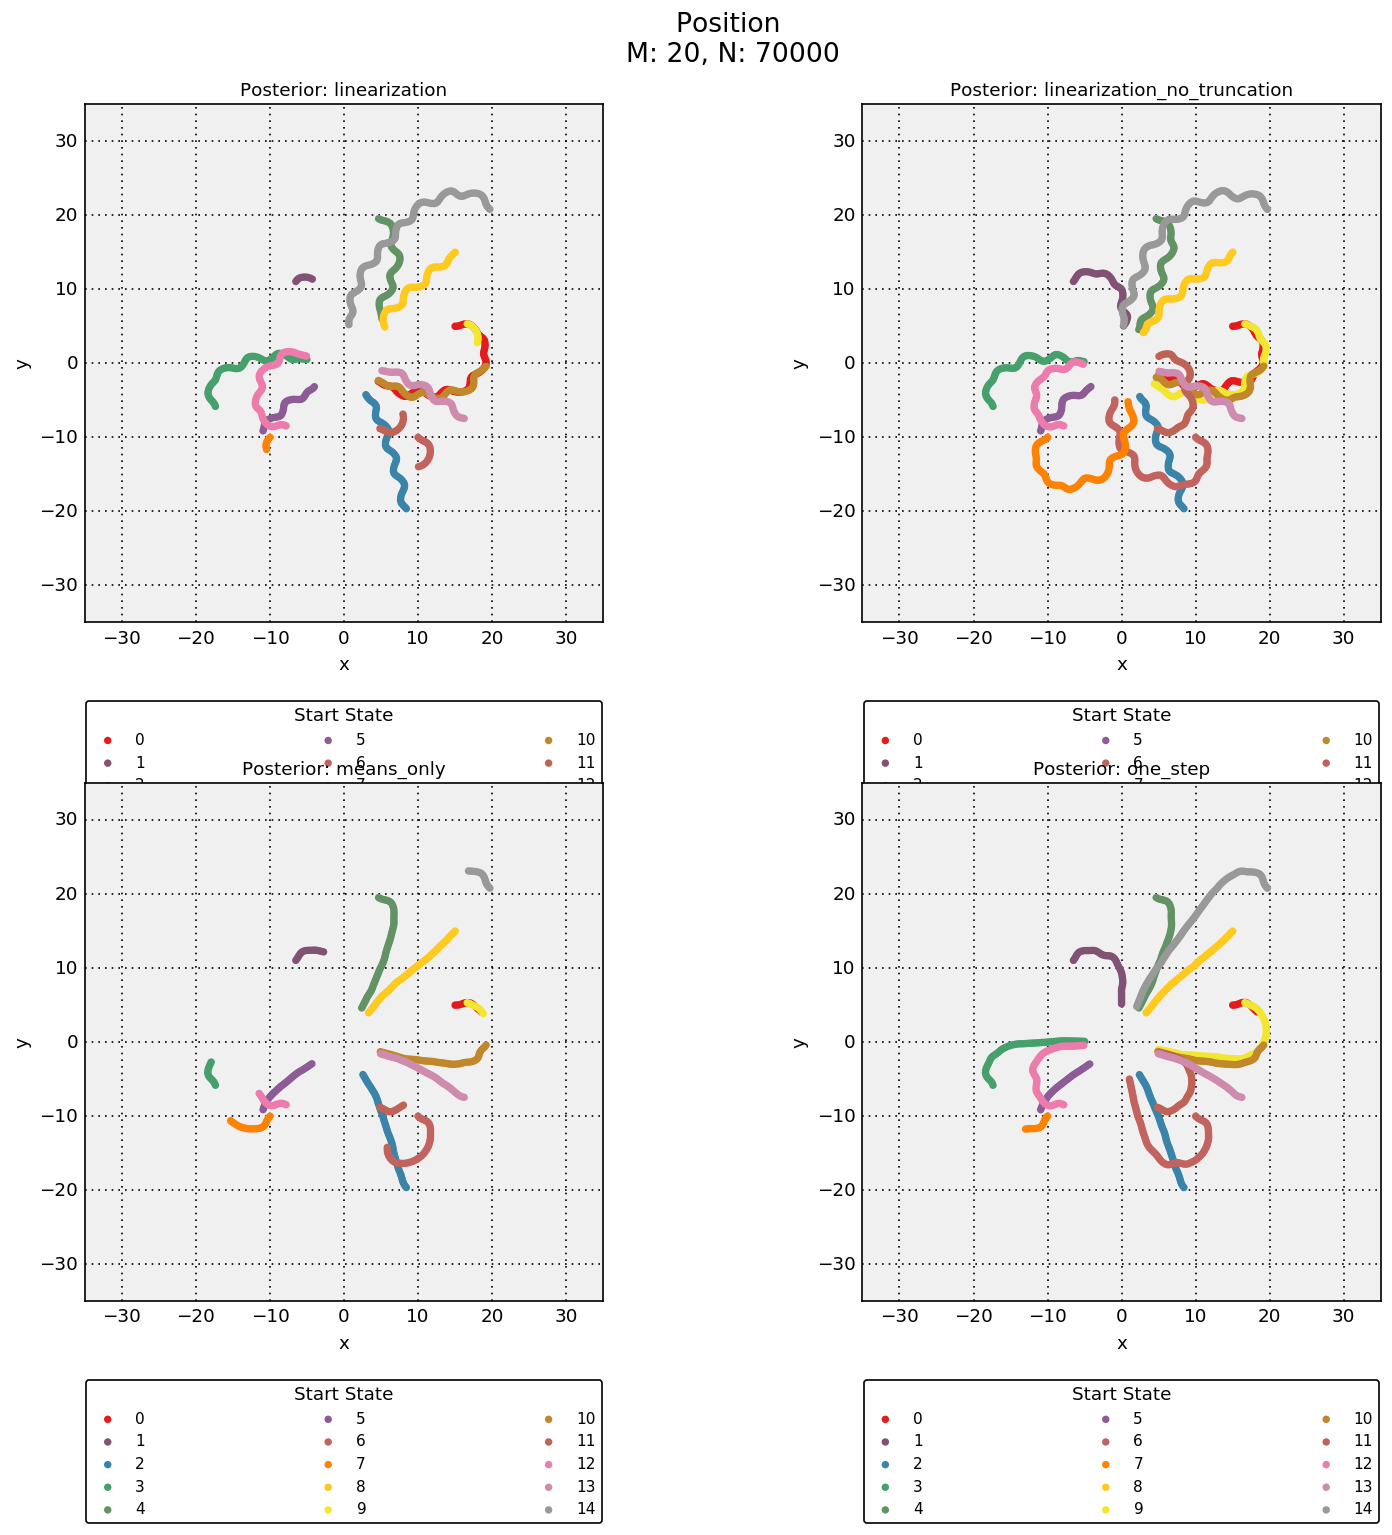
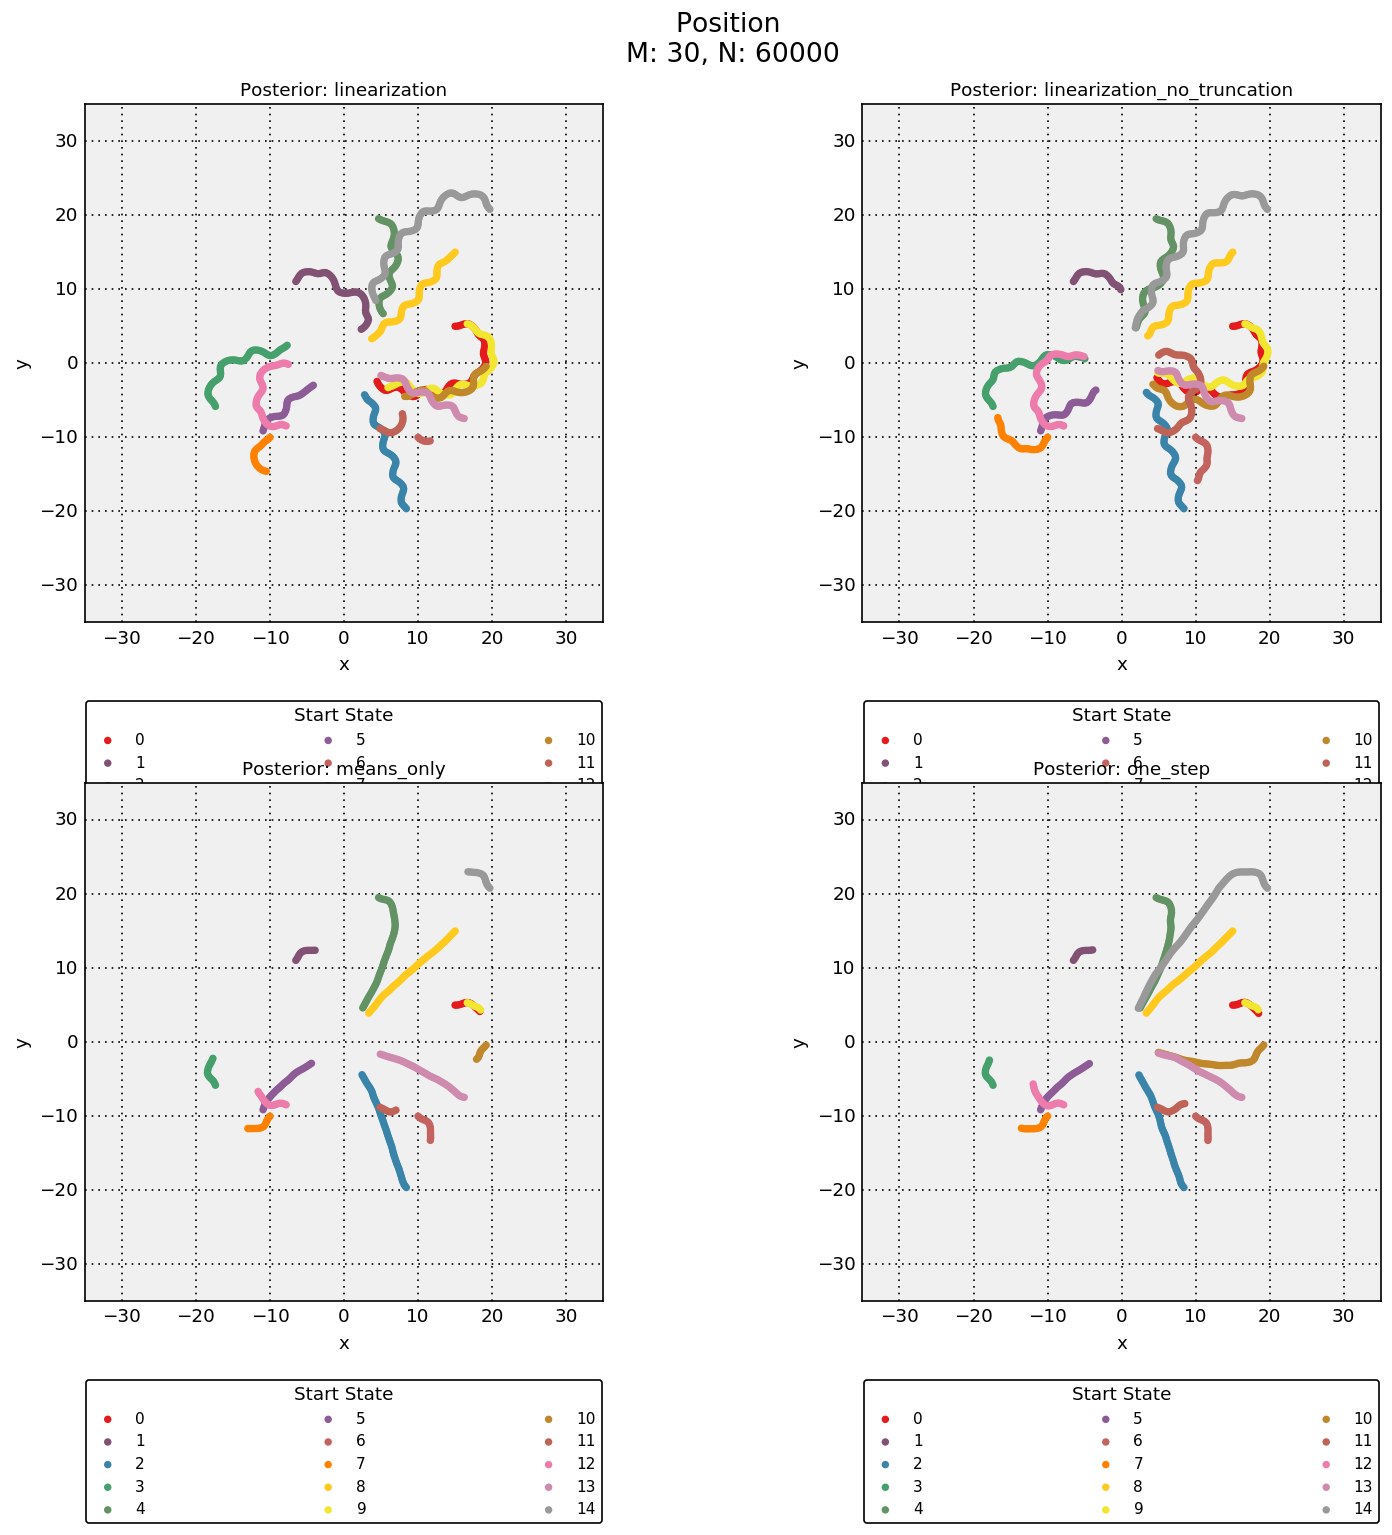
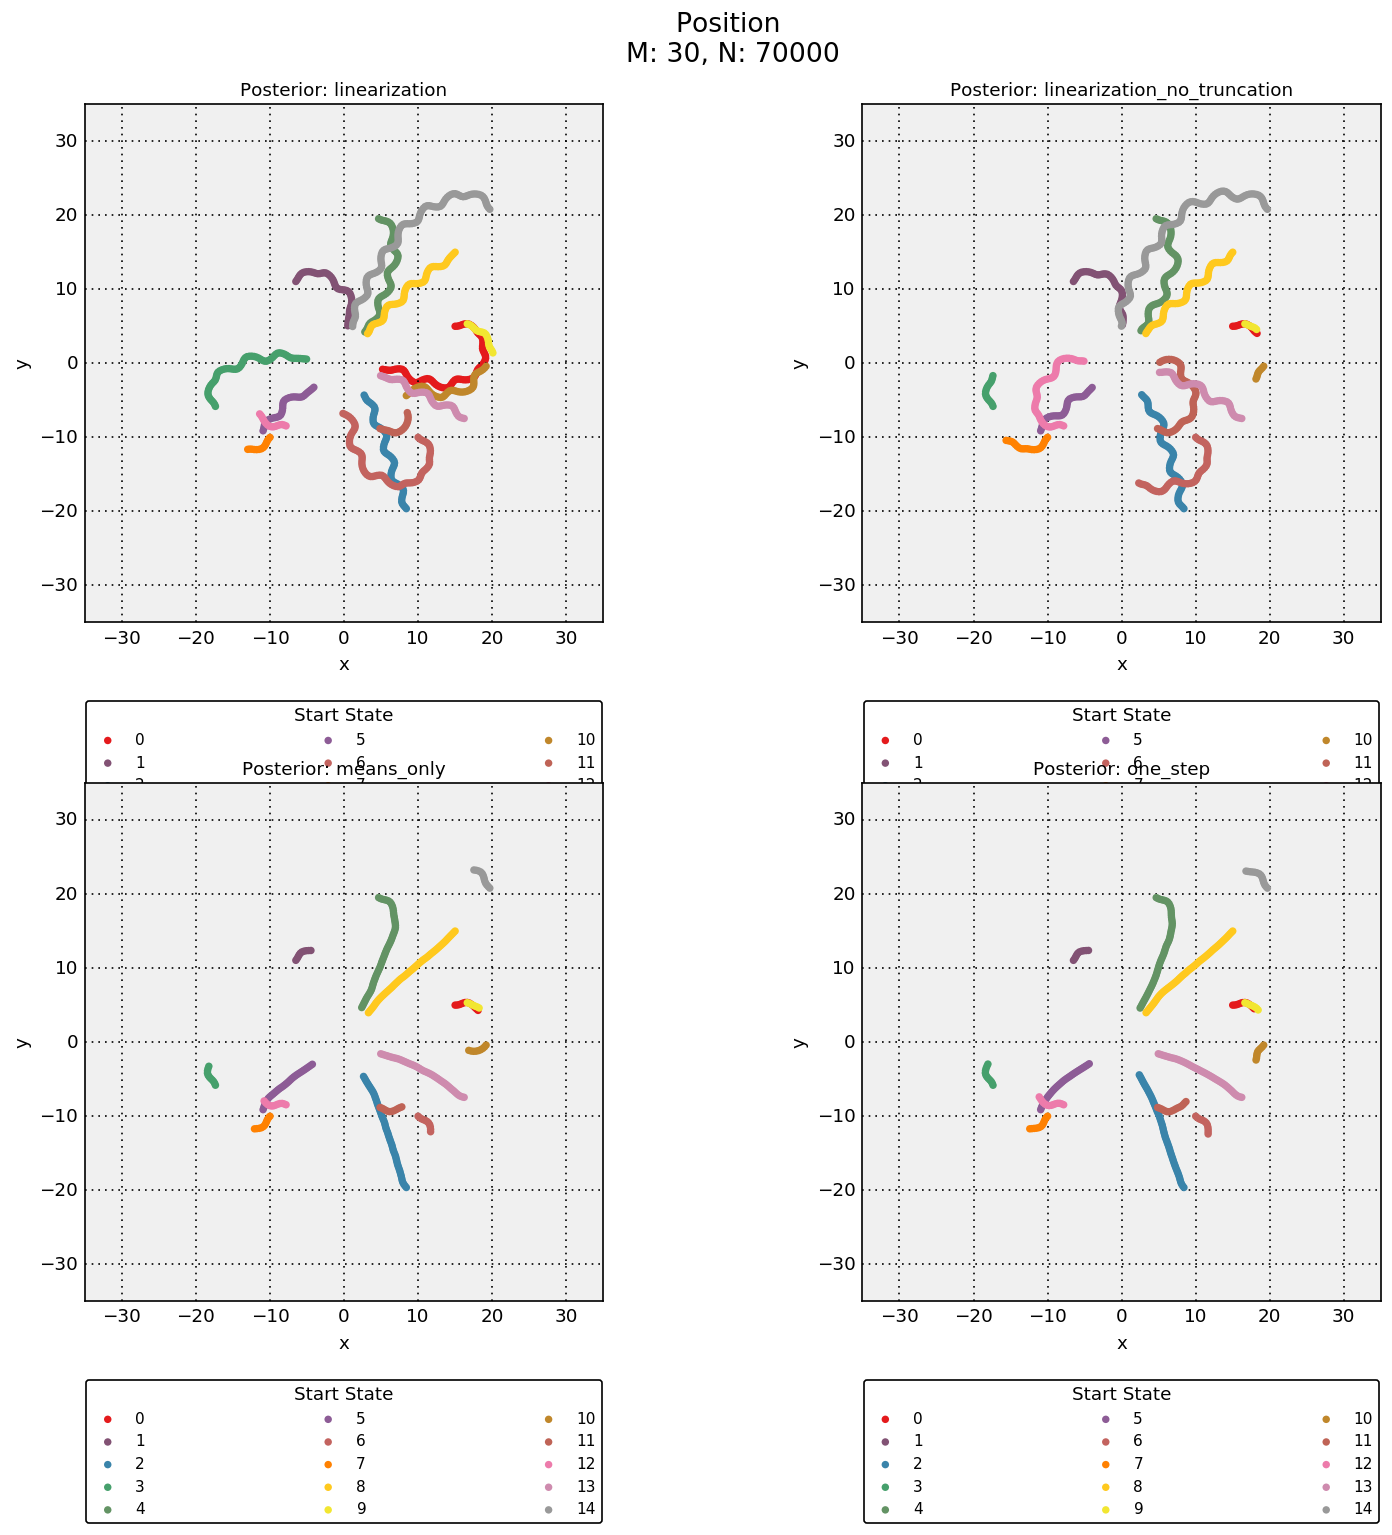
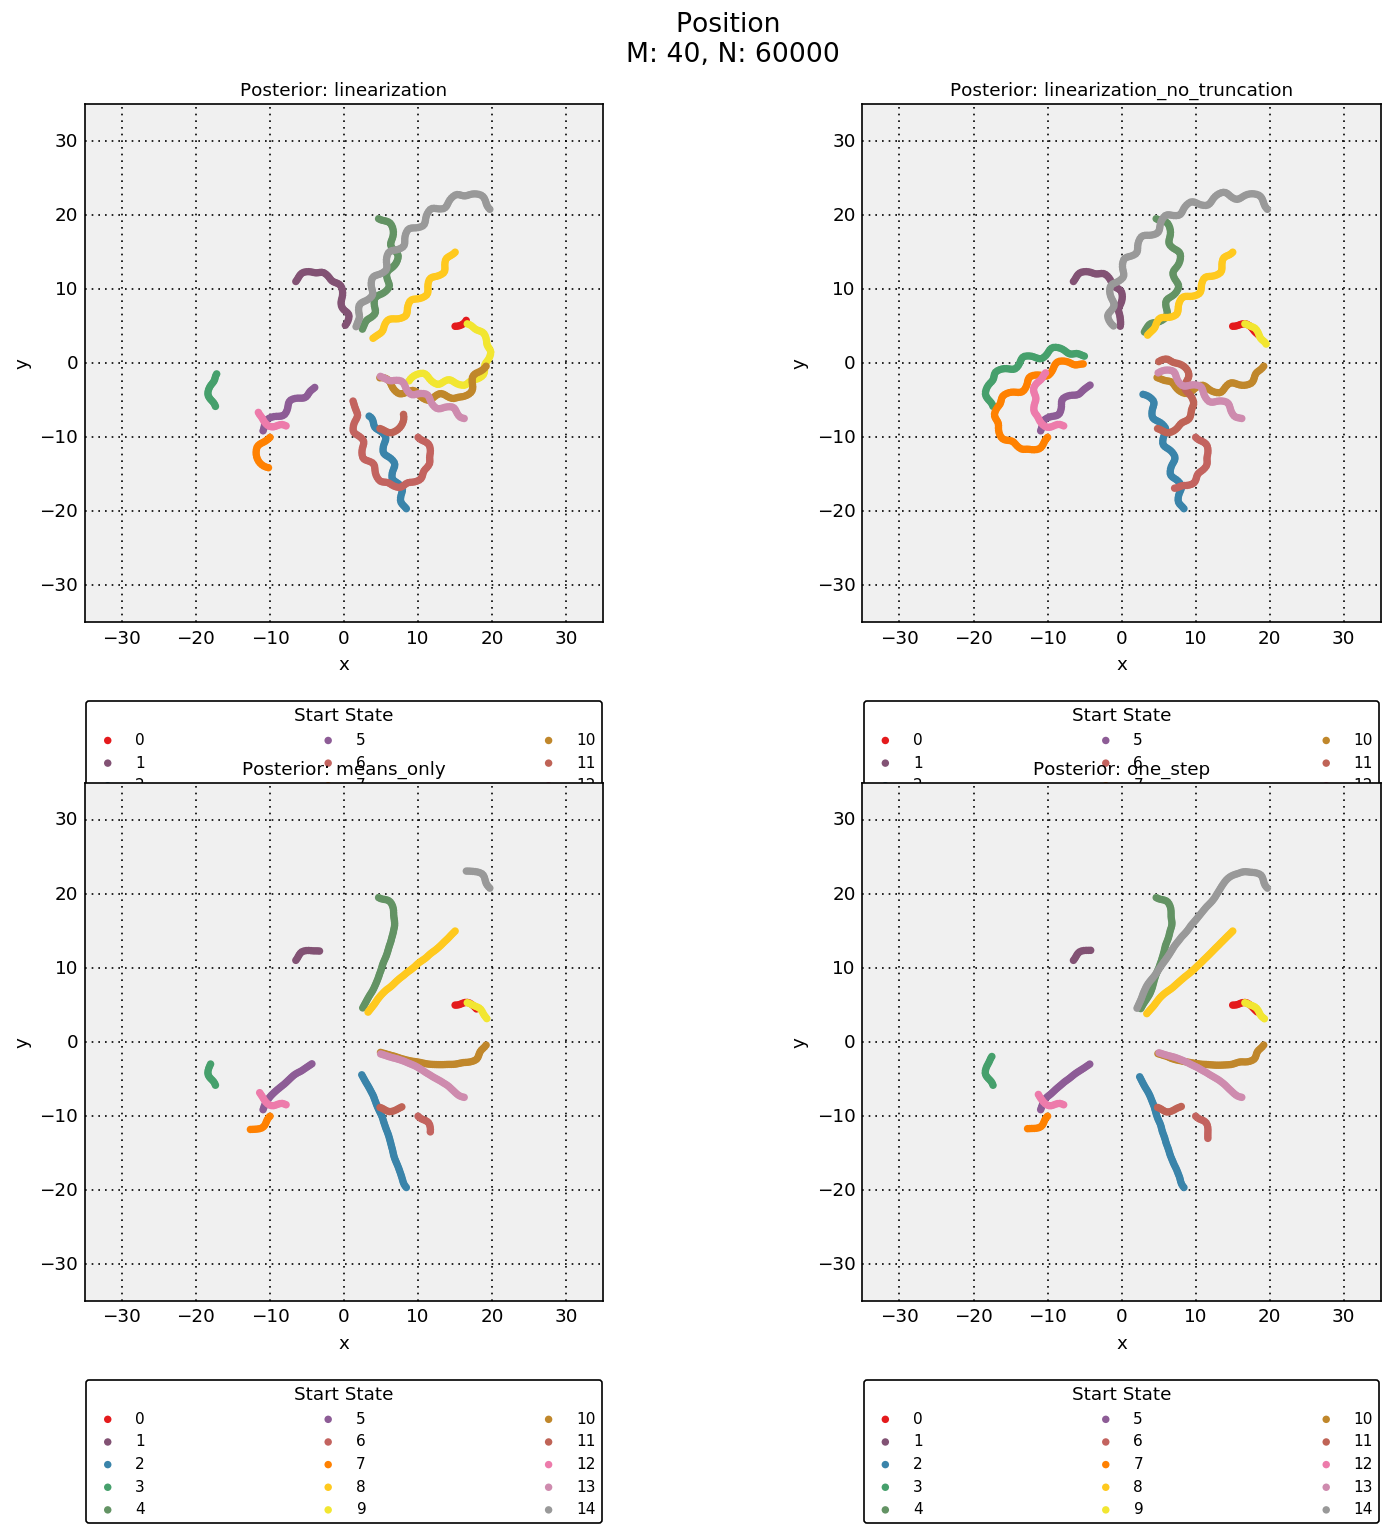
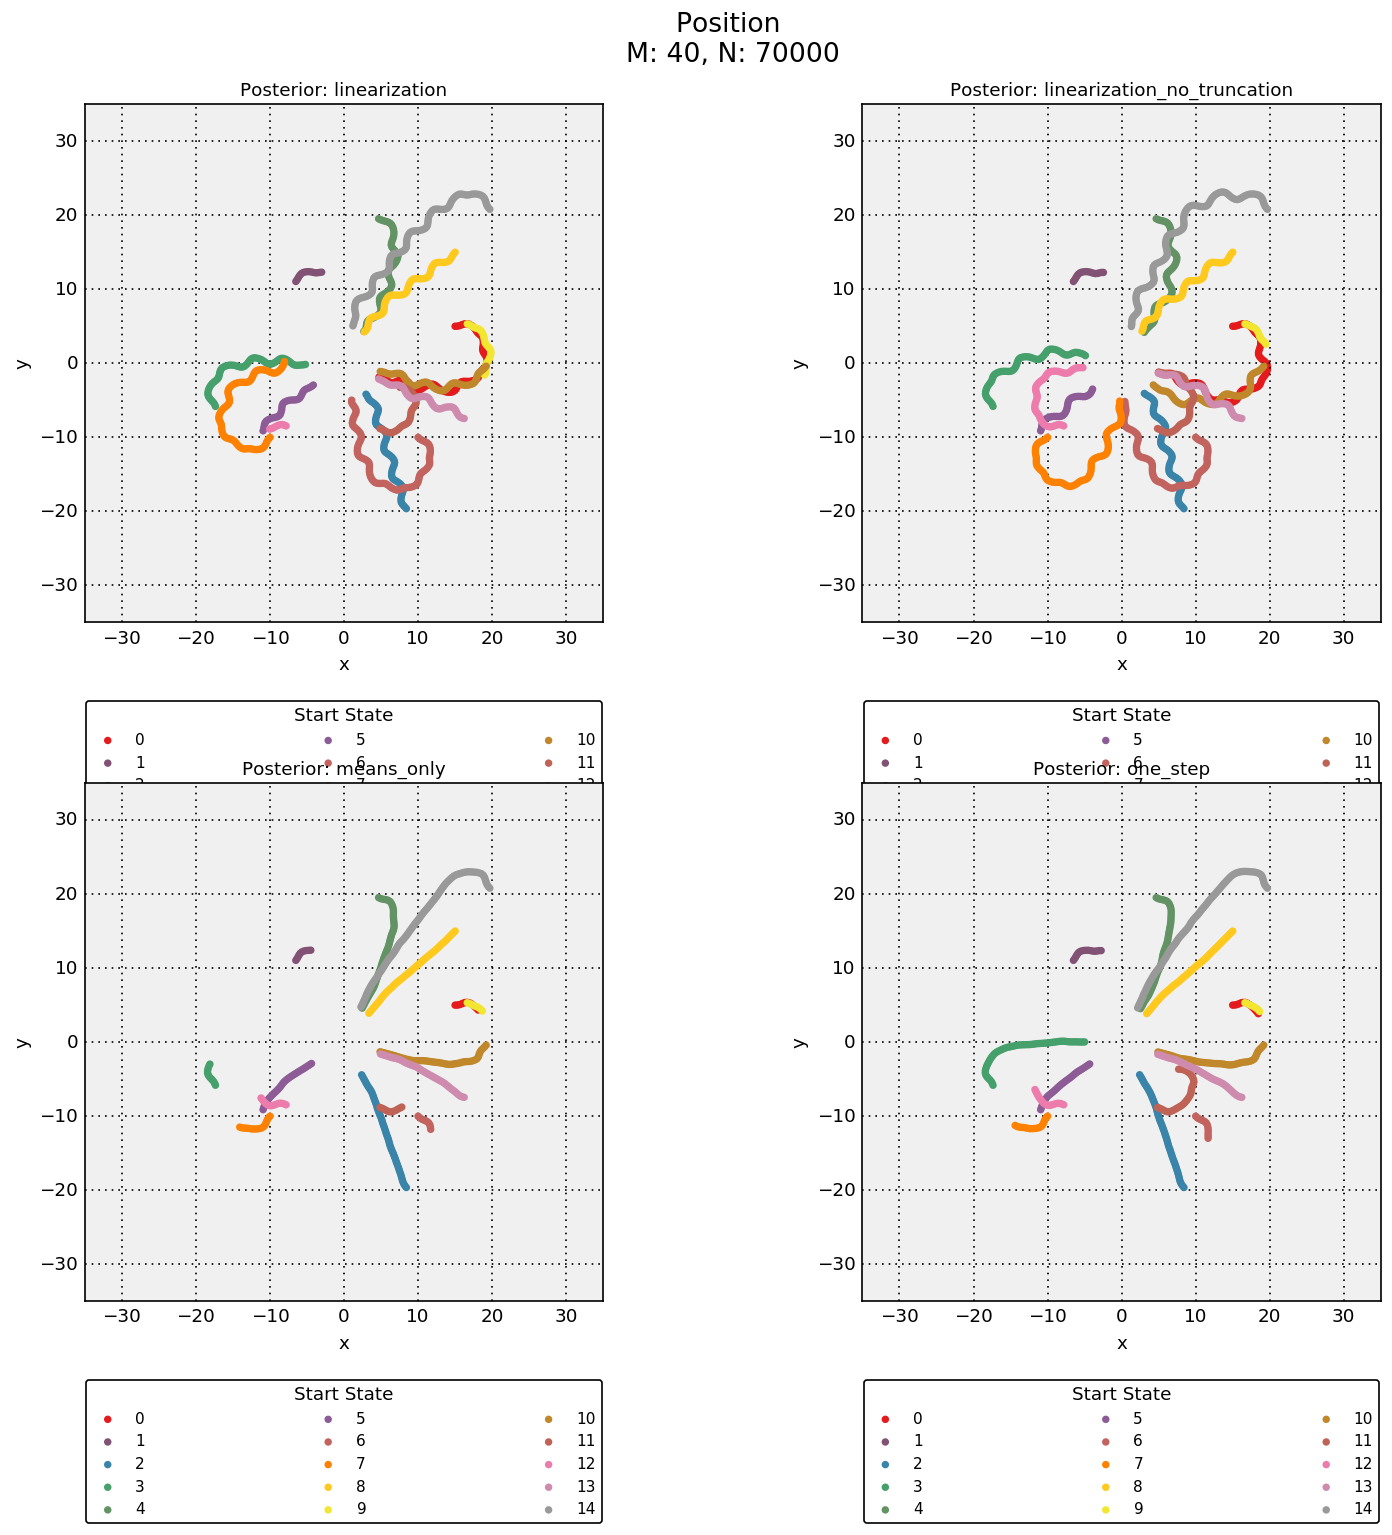
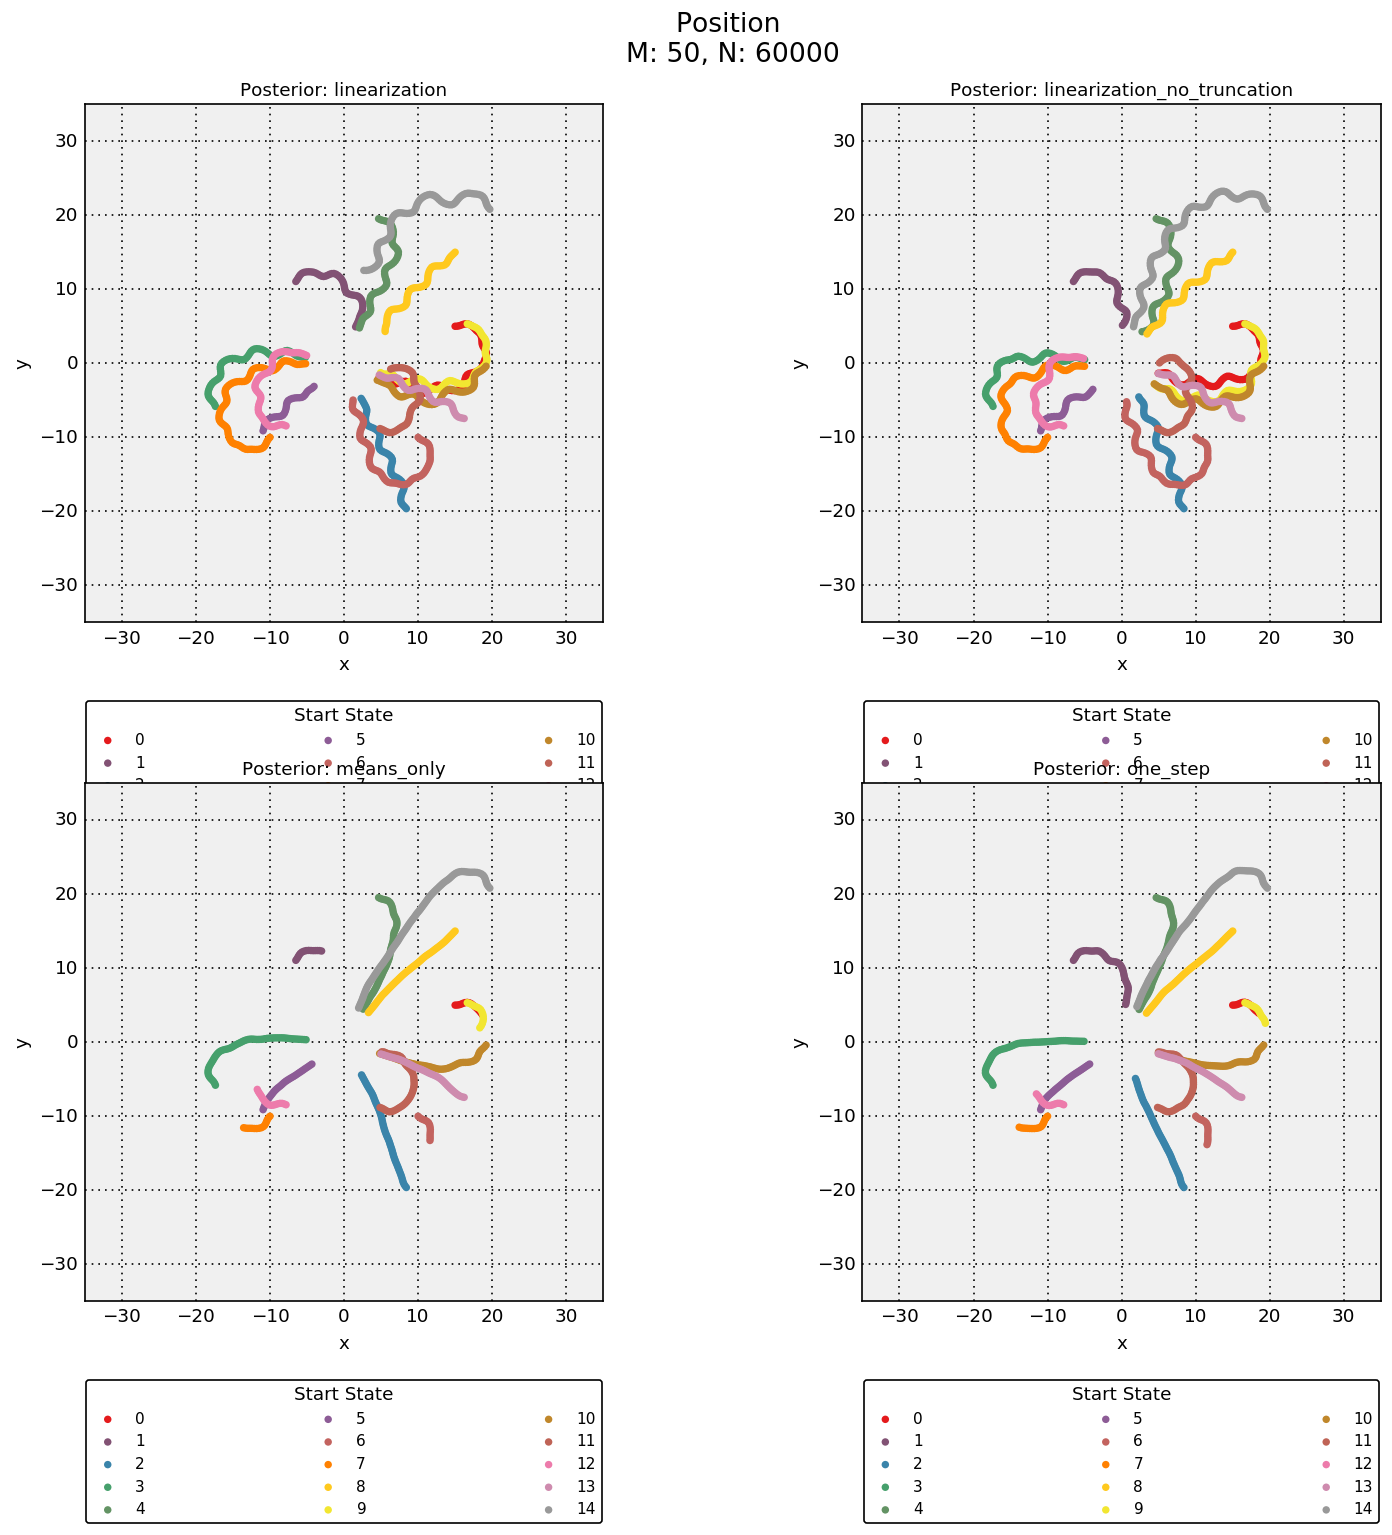
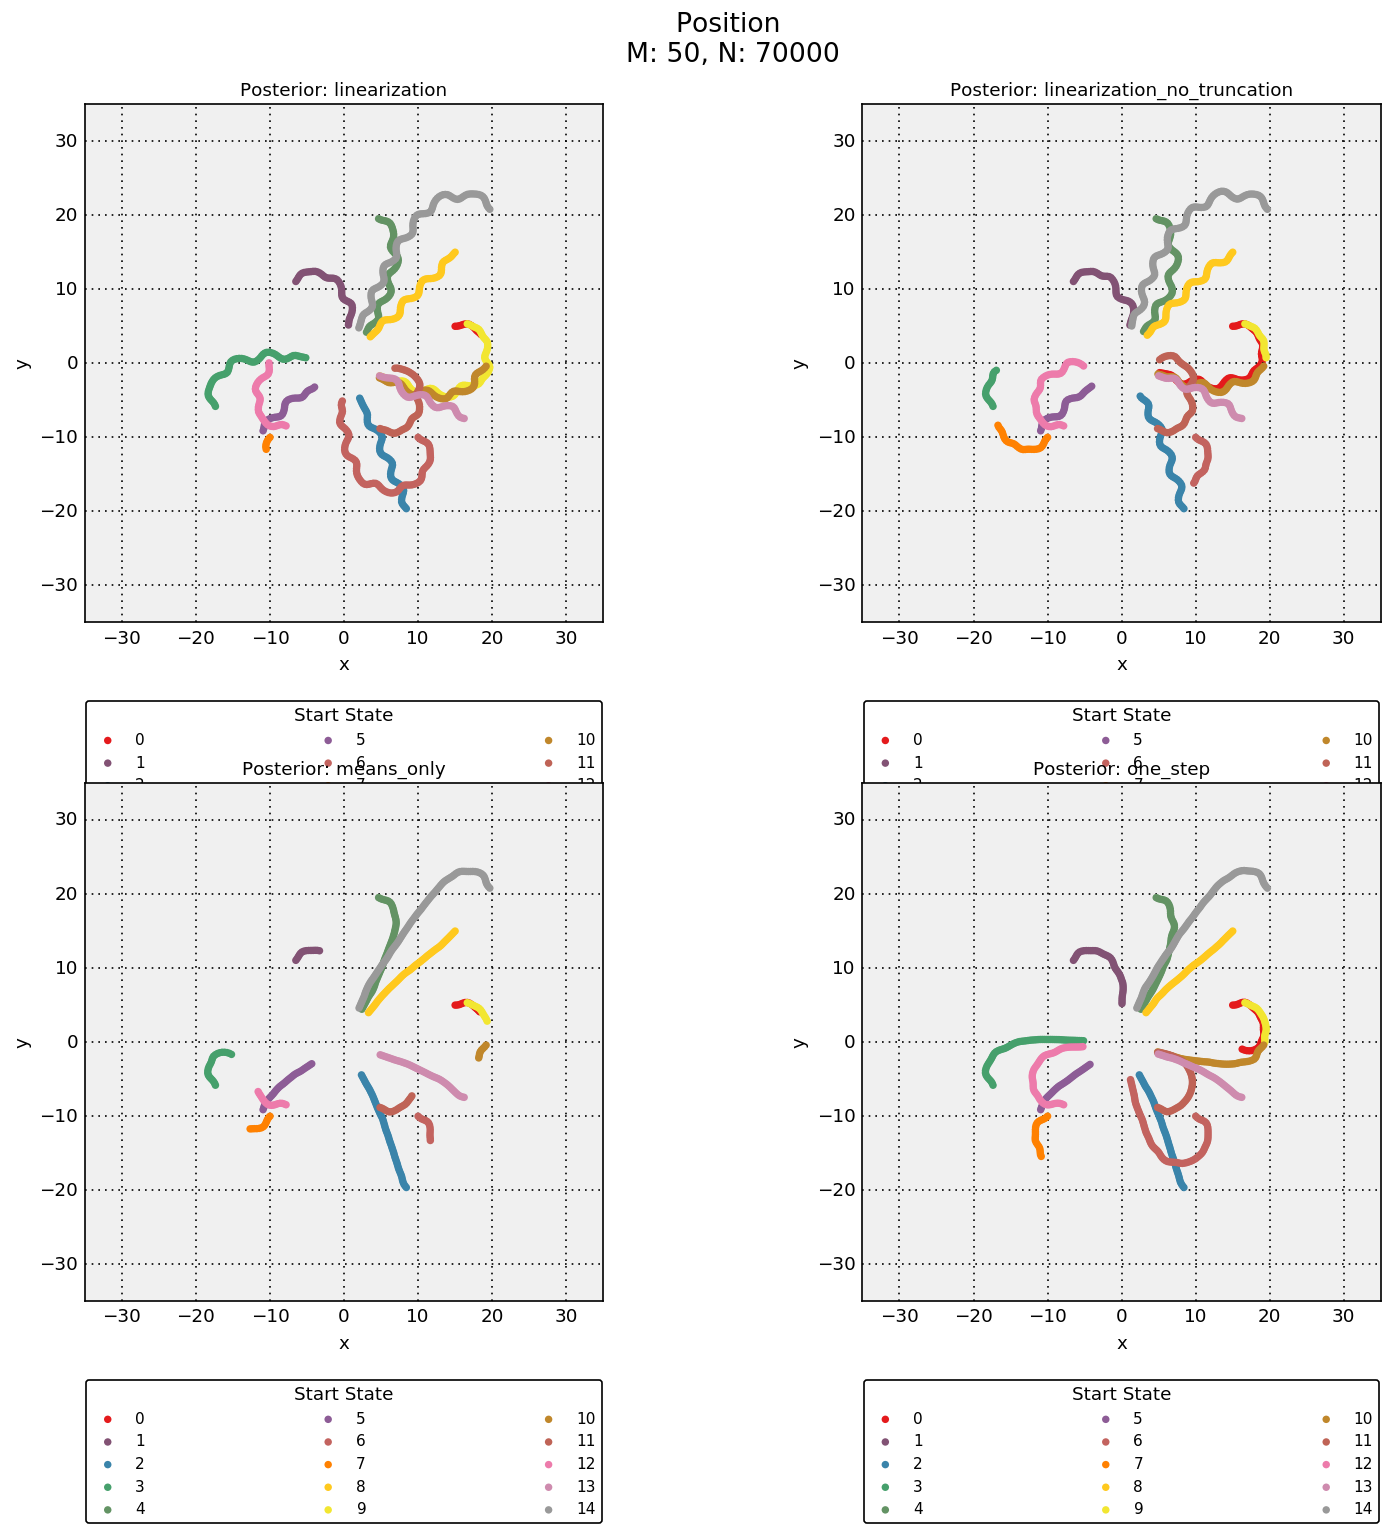
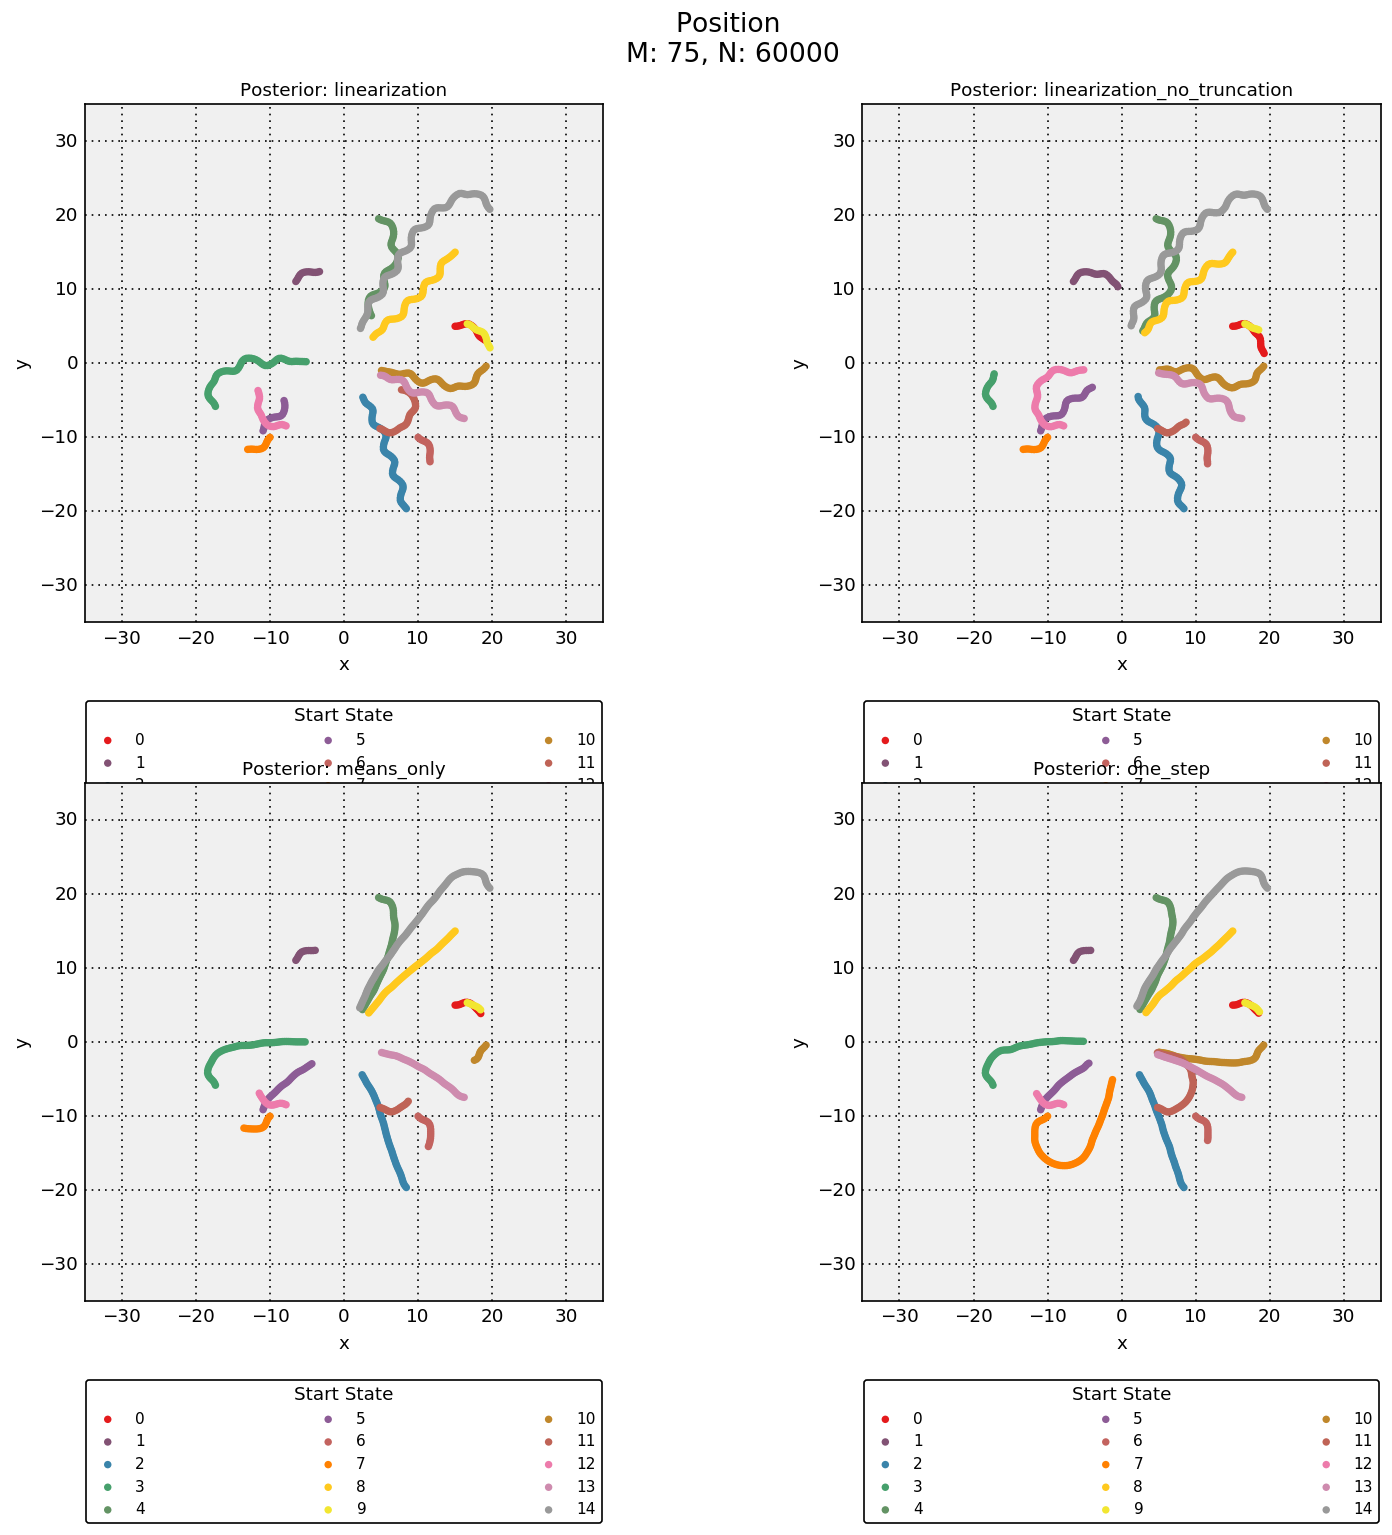
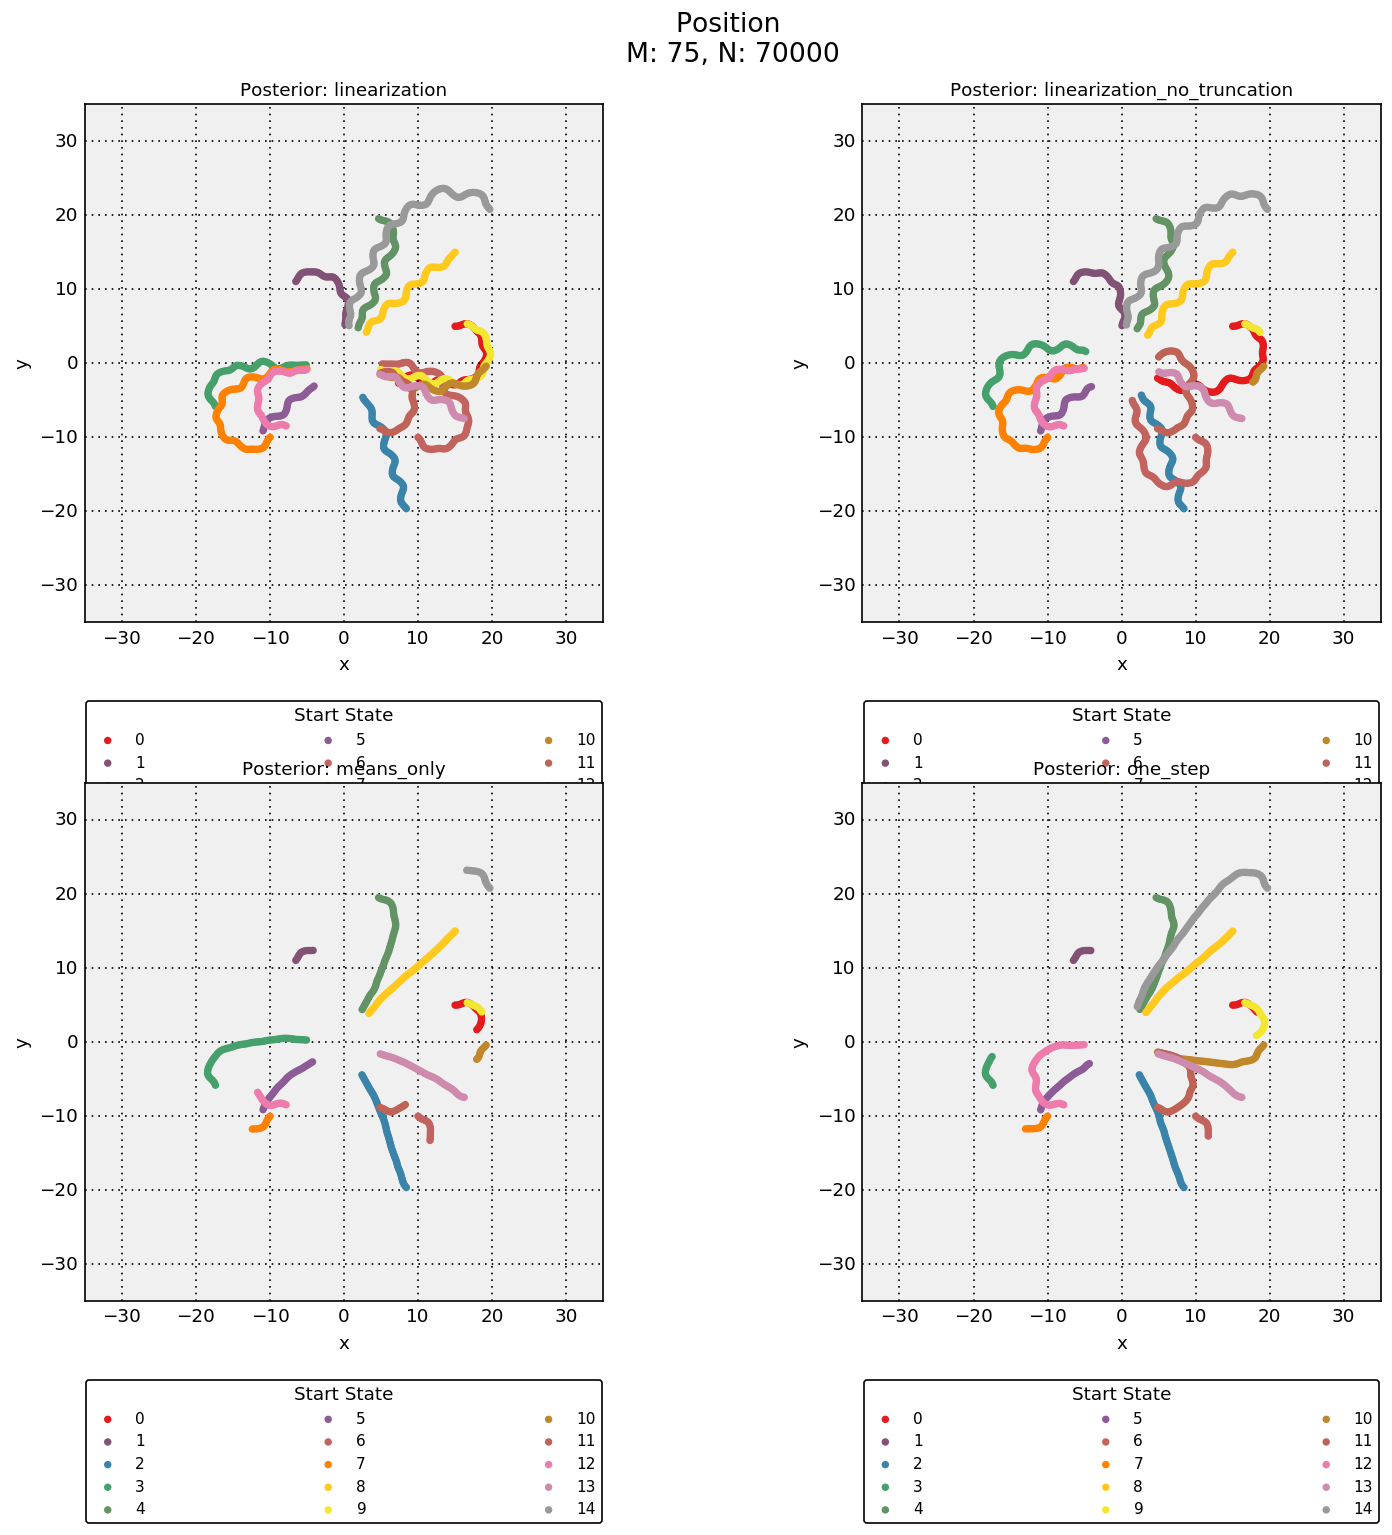
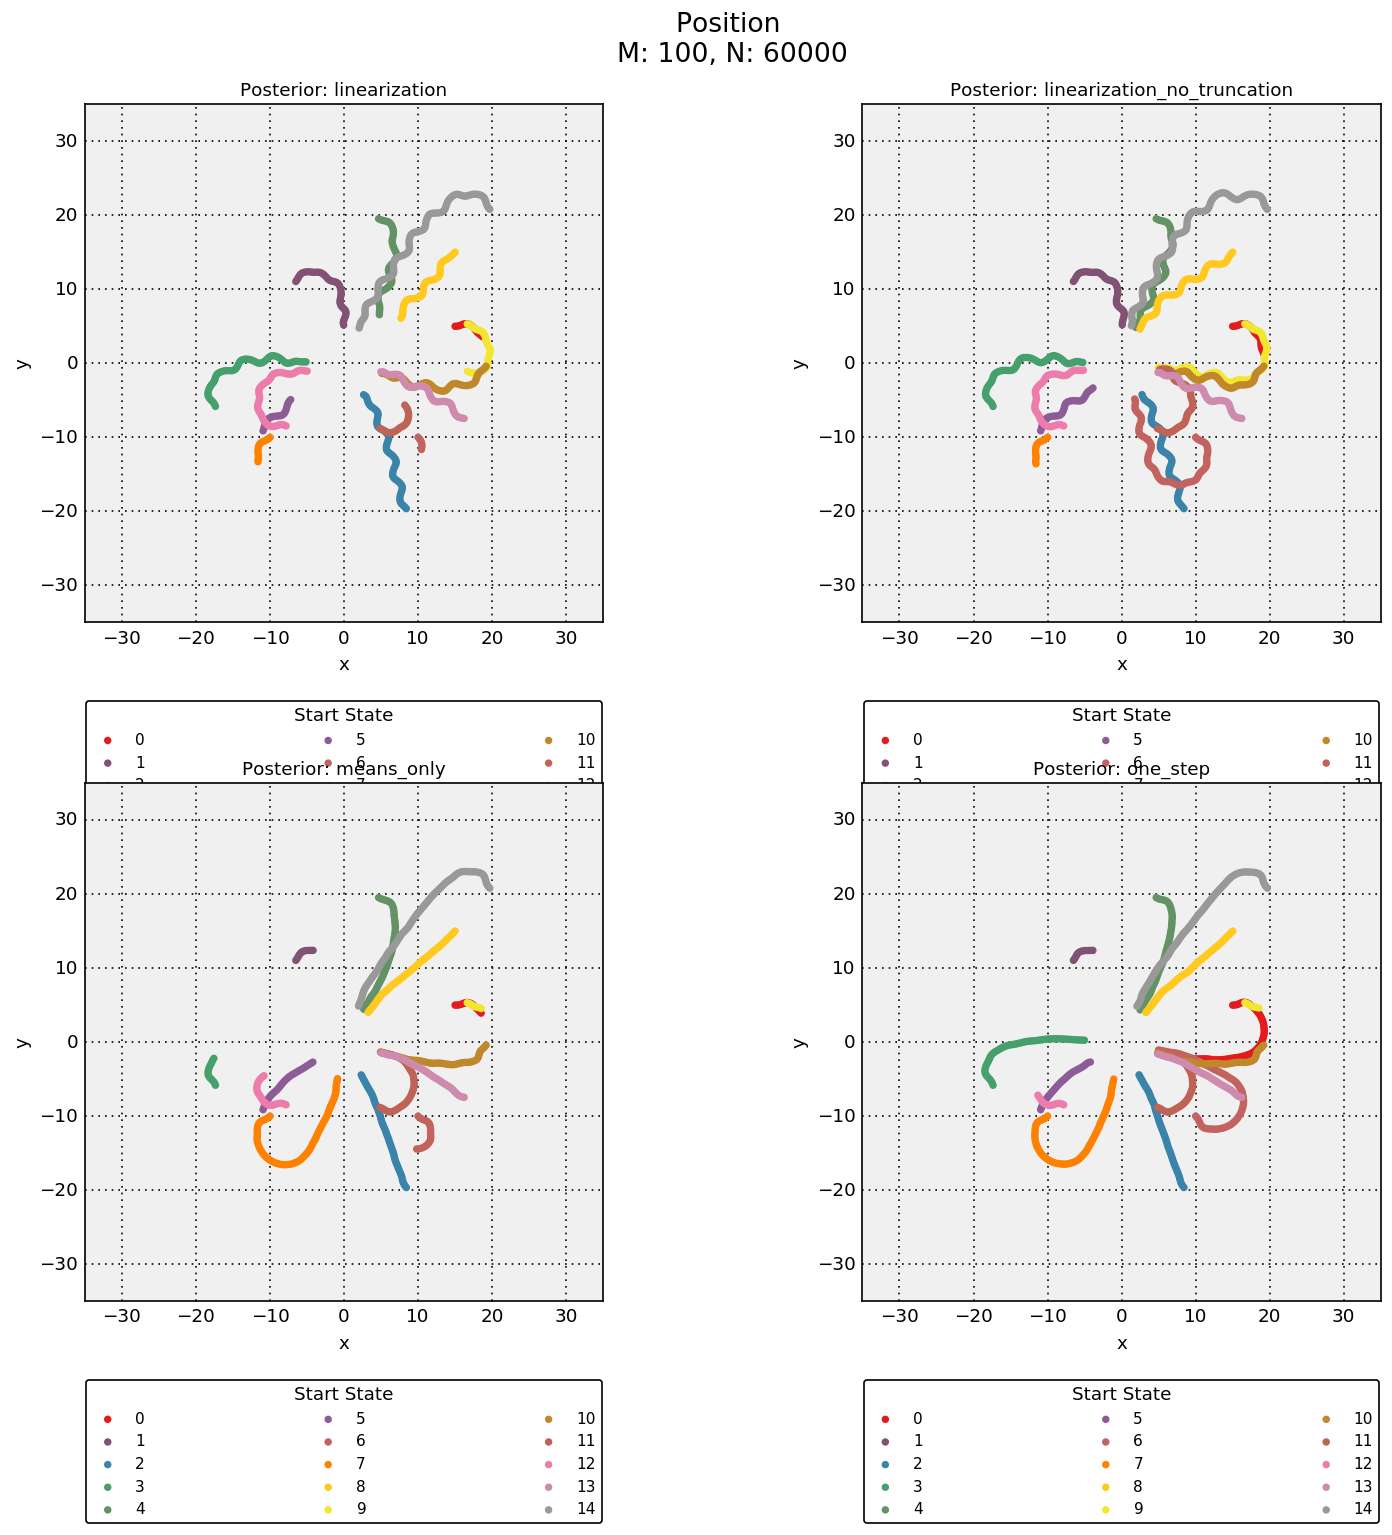
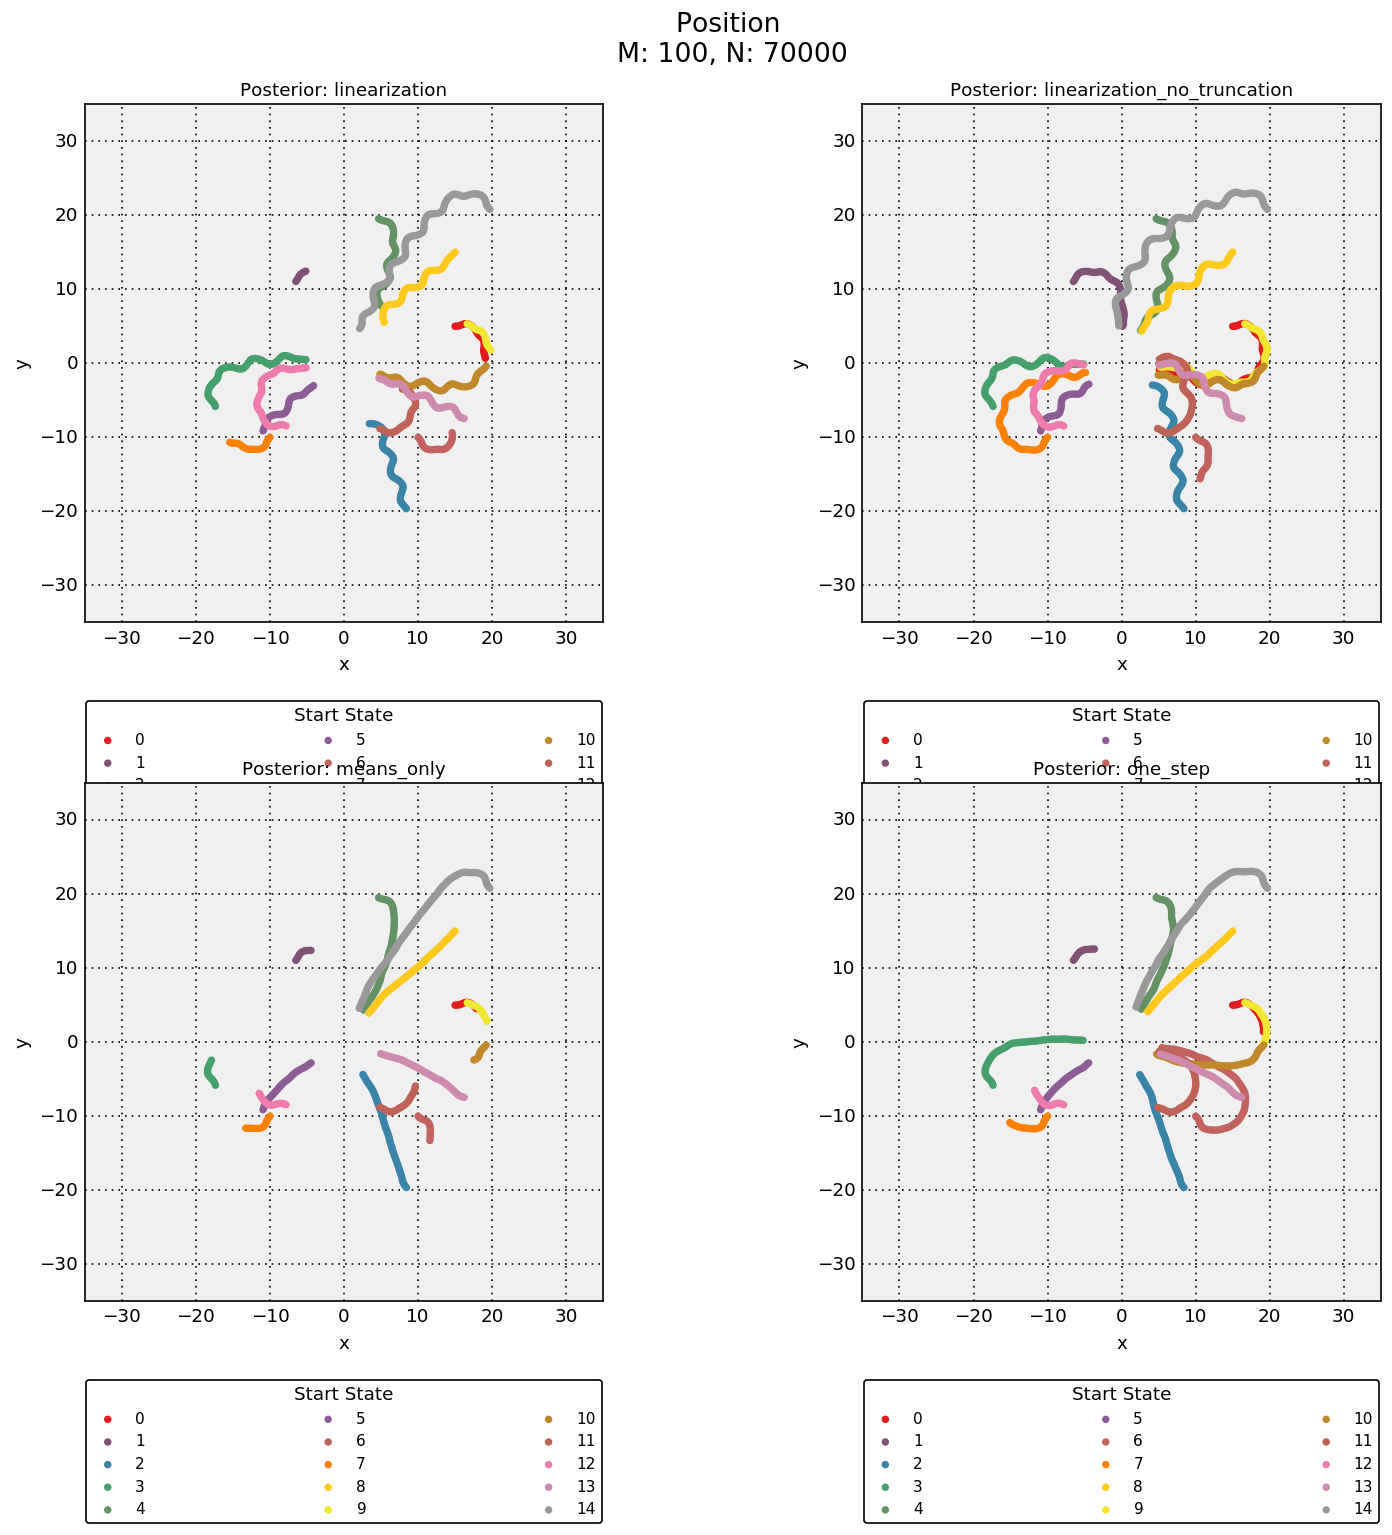
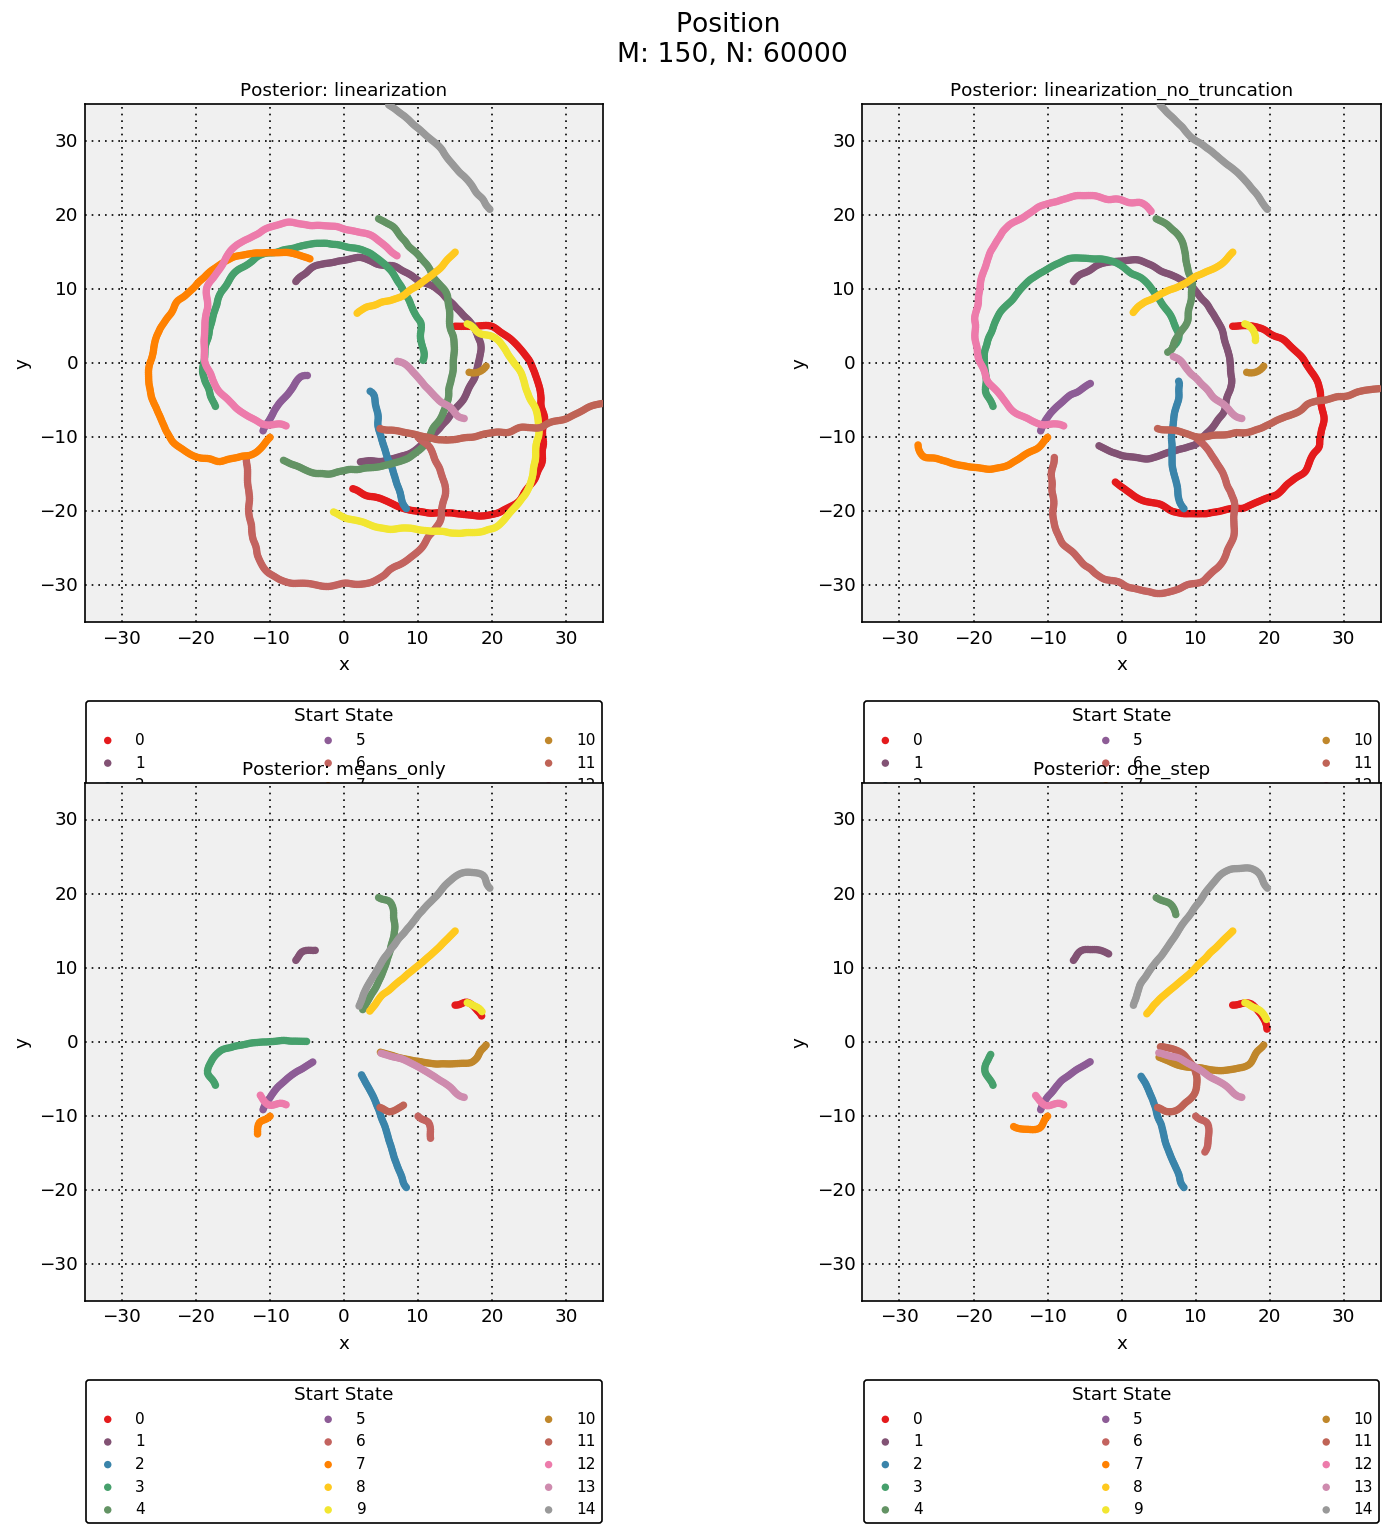
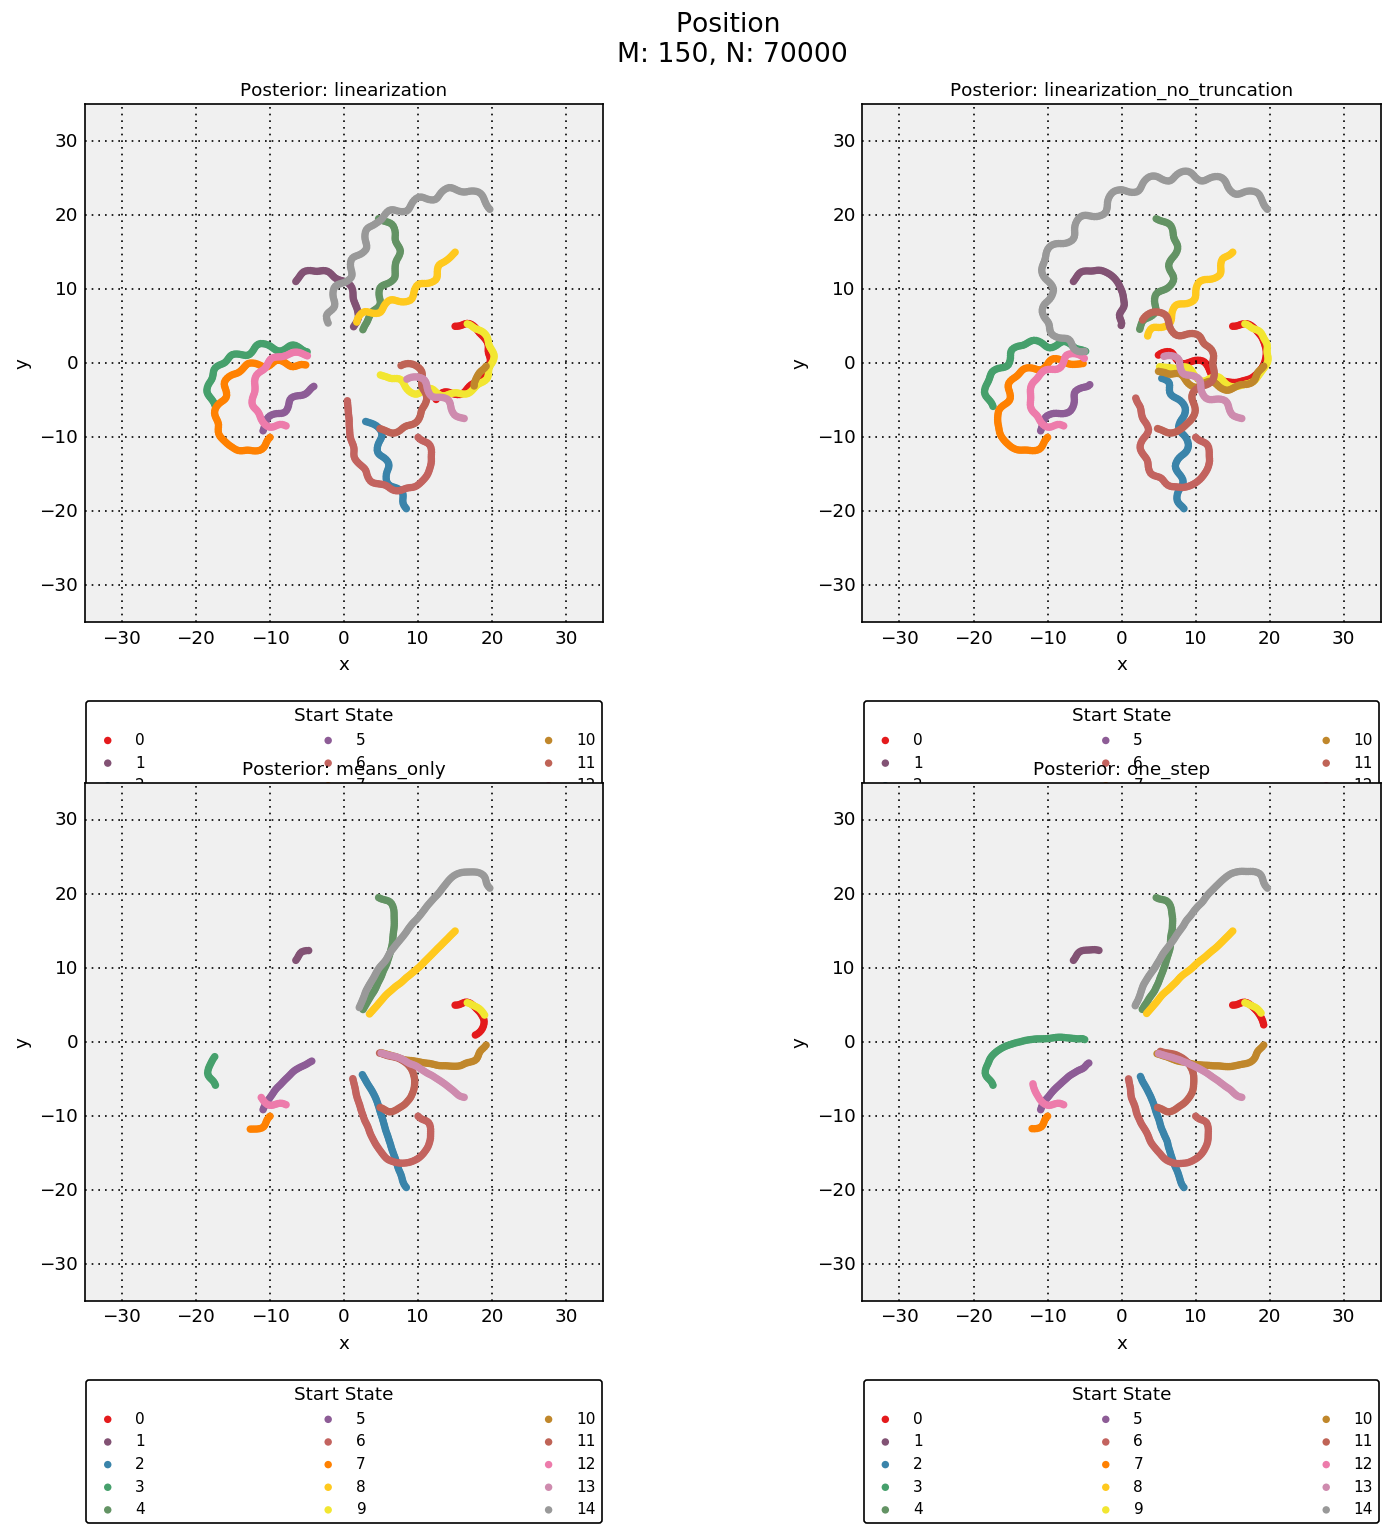

In [6]:
%%opts Curve.State[show_grid=False]

def single_dump(trajectories, add_states=True):
    allpositions = {
        i: position(trajectories[i])
        for i, trajectory in enumerate(trajectories)
        if trajectory is not None
    }
    position_overlay = hv.NdOverlay(allpositions, kdims=['Start State']).relabel(label="Position")
    
    if not add_states:
        return position_overlay
    else:
        allstates = {
            i: hv.GridMatrix(state(trajectories[i]))
            for i, trajectory in enumerate(trajectories)
            if trajectory is not None
        }
        return position_overlay + hv.HoloMap(allstates, kdims=['Start State']).collate()
    
hmap = hv.HoloMap({
        (posterior, N, M): single_dump(trajectories[dump_name], add_states=False)
        for dump_name in trajectories
        for posterior, N, M in [parse_path(dump_name)]
    }, kdims=["Posterior", "N", "M"]).collate()

hmap.layout("Posterior").cols(2)

In [7]:
%%opts NdOverlay[show_legend=False]

plots = hmap.select(M=50, N=60000)

renderer = hv.Store.renderers['matplotlib']
plot = renderer.get_plot(plots)
for i, _ in enumerate(plot):
    plot.update(i)
    renderer.save(plot, 'positions_%s' % i, fmt='png')